In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import gensim
import seaborn as sns
from matplotlib import pyplot as plt
import re
import plotly.express as px
# import pyLDAvis
# import pyLDAvis.gensim
from wordcloud import WordCloud
from sklearn.cluster import DBSCAN
import numpy as np
import pickle
import umap
import warnings
warnings.filterwarnings('ignore')

# Initialization



In [ ]:
PATH = '/content/gdrive/MyDrive/Dataset-yahoo-answer/'

# Read data

In [ ]:
df= pd.read_pickle(PATH+'/lda/saved/data.pkl')

In [ ]:
df

,topic,title,question,answer,processed_answer,processed_length
0,9,What makes friendship click?,How does the spark keep going?,good communication is what does it. Can you m...,"[good, communication, move, beyond, small, tal...",20
1,2,Why does Zebras have stripes?,What is the purpose or those stripes? Who do t...,this provides camouflage - predator vision is ...,"[provide, camouflage, predator, vision, usuall...",9
3,4,What is the difference between a Bachelors and...,NaN,One difference between a Bachelors and a Maste...,"[one, difference, bachelor, master, degree, re...",76
4,3,Why do women get PMS?,NaN,Premenstrual syndrome (PMS) is a group of symp...,"[premenstrual, syndrome, pm, group, symptom, r...",45
6,5,what is the best podcast to subscribe to?,NaN,This Week in Tech is a great podcast. It's ho...,"[week, tech, great, podcast, host, leo, laport...",48
...,...,...,...,...,...,...
59994,9,guys only pleez?,is their anyone out their 4 me who are 13to15 ...,omg i love that in a girrl\nim not looking for...,"[omg, love, girrlim, look, sexbut, want, relat...",9
59995,9,"if you could be any fantasy figure, who would ...",NaN,"The invisible man, I'd be straight into the gi...","[invisible, man, straight, girl, change, room]",6
59996,8,Tell me something about life most people don't...,"Do you know anything about life, or words of w...",That there is a hell and everyone thinks their...,"[hell, everyone, think, go, world, go, dont, t...",13
59998,6,est ce que DOMENECH est un entraineur: 1: de f...,NaN,de foot mais pas pour être sélectionneur d'une...,"[de, foot, mais, pa, pour, tre, lectionneur, u...",22


# Load Model

In [ ]:
mallet_lda_model = pd.read_pickle(PATH+'/lda/saved/mallet_lda.model')
gensim_model = pd.read_pickle(PATH+'/lda/saved/gensim.model')
corpus = pd.read_pickle(PATH+'/lda/saved/courpus.corp')
dictionary = pd.read_pickle(PATH+'/lda/saved/dictionary.dict')

# Helper functions

In [ ]:
def plot_word_cloud(mallet_lda_model, num_topics):
    '''
    This function takes mallet model and number of topics for the mallter model as 
    inputs and produces a wordcloud plot for each topic.
    
    Inouts:
        mallet_lda_model: mallet lda model produces by gensim mallet lda wrapper
    
        num_topics: an integer ind9icating number of topics used to build
        mallet_lda_model
    
    Returns: None
    
    Display:
        Wordcloud of each topic. Bigger words in the wordcloud means higher probability
        words in that topic. Will show top 15 words per topic.
    '''
    
    wordcloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  prefer_horizontal=1.0)
    
    # getting top 20 words in each topic along with their proabilities 
    topics =  mallet_lda_model.show_topics(formatted=False, num_topics=-1, num_words=20)
    
    #plotting wordcloud in subfigures
    fig, axes = plt.subplots( int(num_topics / 2), 2, figsize=(10,30), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        wordcloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(wordcloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    fig.savefig(PATH+'/lda/wordcloud.png')

In [ ]:
def get_doc_topic_dist(mallet_lda_model):
    '''
    This function finds the document topic distribution
    
    Input:
        mallet_lda_model: mallet lda model produces by gensim mallet lda wrapper
        
    Returns:
        doc_topics: a (d,t) dimensional numpy array of document topic distribution 
        where d is the number of documents and t is the number of topics
    '''
    doctopic_file = mallet_lda_model.fdoctopics() #getting location of the document topic distribution file
    doc_topics_df = pd.read_csv(doctopic_file, delimiter = '\t', header=None)
    doc_topics = doc_topics_df.iloc[:, 2:].to_numpy() #first two column does not correspond to doc topic distribution. So removing them 
    
    return doc_topics

In [ ]:
def find_most_prominant_topics(mallet_lda_model, corpus):
    '''
    This function takes mallet lda model and corpus as inputs
    and find the most prominent topic in each document.
    
    Inputs:
        mallet_lda_mode: mallet lda model produces by gensim mallet lda wrapper
        
        corpus: gensim corpus
    
    Returns:
        dominant_topics: a (n,) numpy array where n indicates the
        number of documents. Each entry in the array is the most prominant
        topic for that corresponding document
        
        topic_percentages: a (n,) numpy array where n indicates the
        number of documents. Corresponding probability of the most
        prominent topic
        
    '''
    topic_percentages = []
    
    doc_topics = get_doc_topic_dist(mallet_lda_model)
    
    dominant_topics = np.argmax(doc_topics, axis = 1)
    topic_percentages = np.max(doc_topics, axis = 1)
  
    return dominant_topics, topic_percentages

In [ ]:
def plot_most_freq_topics(dominant_topics, topic_percentages):
    '''
    This function produces a barplot of topic by number of documents prominently
    represented.
    
    Inputs:
        dominant_topics: a (n,) numpy array where n indicates the
        number of documents. Each entry in the array is the most prominant
        topic for that corresponding document
        
        topic_percentages: a (n,) numpy array where n indicates the
        number of documents. Corresponding probability of the most
        prominent topic
        
    '''
    df = pd.DataFrame({
        'Dominant topic': dominant_topics,
        'Topic percentage': topic_percentages
    })
    
    fig = px.histogram(df, x='Dominant topic', hover_data=['Dominant topic', 'Topic percentage'], color='Dominant topic')
    fig.write_html(PATH+'/lda/most_freq_topics.html')
    fig.show()
                 
#     sns.countplot(data=df, x='Dominant topic')
#     plt.ylabel('# of Documents')

In [ ]:
def view_top_document_topicwise(topic_id, df, k):
  '''
    This function prints top k sentences for a given topic
    
    Inputs:
        df: a dataframe object that contains at least the following
        columns: combine_text, dominant_topic, dominant_topic_prob
        
        topic_id: an integer of topic id
        
        k: an integer that denotes number of documents to print
        
    returns: new dataframe
    
    '''
  df_new = df[df['dominant_topic'] == topic_id].sort_values(by=['dominant_topic_prob'], ascending=False)
  return df_new.head(k)


In [ ]:
def get_umap_encoding(distribution):
    '''
    Given a distribution, this function transforms the distribution 
    in a two dimensional space using umap
    
    Inputs: 
        distribution: a (n, d) dimensional numpy array
    
    Returns:
        embedding: a (n, 2) dimensional embedding of the distribution
    '''
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(distribution)
    
    return embedding

In [ ]:
def plot_topics(embeddings, data_df):
    '''
    This function plots all documents by their most prominent topic in a 
    two dimensional space.
    
    Inputs:
        embeddings: a (d,2) dimensional numpy array where d is the number of documents
        
        dat_df: a pandas dataframe that contains at least dominent_topic column. Each
        entry in the dominent_topic column should give the corresponding dominent topic 
        of the embeddings 
        
    Returns:
        None
    
    Displays:
        a document distribution plot by their most prominent topic
    '''
    df = pd.DataFrame({
        'x': embeddings[:, 0],
        'y': embeddings[:, 1],
        'topic': data_df['dominant_topic'].to_numpy(dtype=np.str)
    })
    
    fig = px.scatter(data_frame= df, x='x', y='y', hover_data=['topic'], color = 'topic' )
    fig.write_html(PATH+'/lda/topic_cluster.html')
    fig.show()

# Topic-word clouds


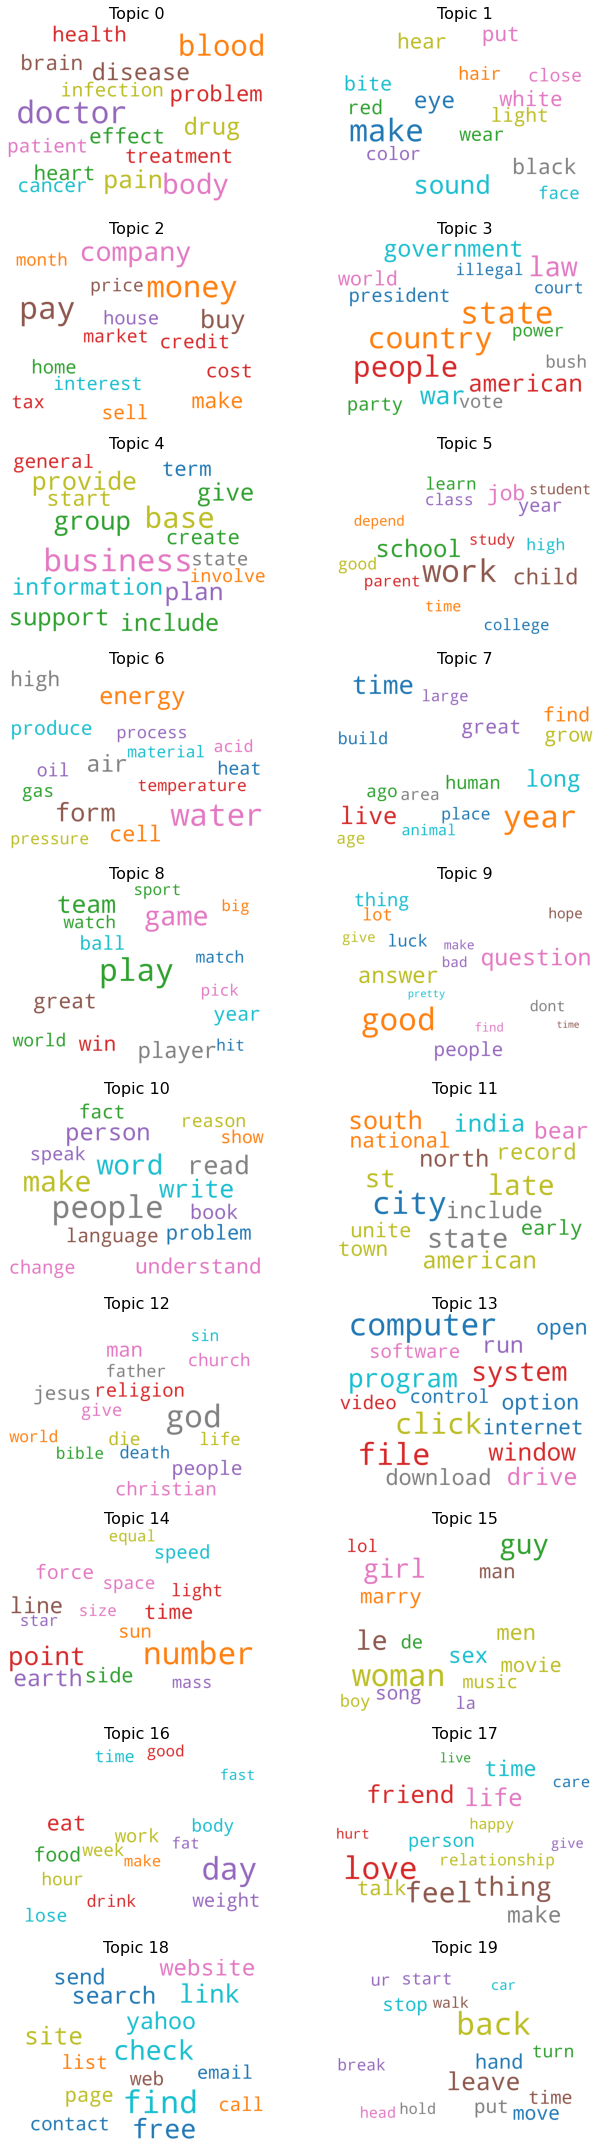

In [ ]:
best_k = 20
plot_word_cloud(mallet_lda_model, best_k)

# Dominant Topic Distribution

In [ ]:
dominant_topics, topic_percentages = find_most_prominant_topics(mallet_lda_model, corpus)
plot_most_freq_topics(dominant_topics, topic_percentages)

# Topic labeling

In [ ]:
df['dominant_topic'] = dominant_topics
df['dominant_topic_prob'] = topic_percentages

In [ ]:
TOPIC_ID = 2
TOP_SENTENCES = 5
NUM_WORDS = 20

df_temp = view_top_document_topicwise(TOPIC_ID, df,TOP_SENTENCES) # topic_id, dataframe, num_instances
df_temp

,topic,title,question,answer,processed_answer,processed_length,dominant_topic,dominant_topic_prob
25921,7,whatr is a roth 401(k)?,NaN,The Roth 401K is a new retirement savings plan...,"[roth, k, new, retirement, save, plan, authori...",332,2,0.594551
23955,7,How does an Investment bank contributes in glo...,NaN,The original purpose of an investment bank was...,"[original, purpose, investment, bank, raise, c...",356,2,0.521333
31296,7,what are the advantages and disadvantages of c...,NaN,Advantages of Credit Cards \n\n\nThere is an i...,"[advantage, credit, card, implicit, guarantee,...",307,2,0.485577
42743,7,what are the delivery/intraday base brokerag...,"how does future,option,derivative and commodit...",reliance money franchisee. He says that the Rs...,"[reliance, money, franchisee, say, r, per, tra...",201,2,0.484127
25350,7,"whats the mean of ""operating profit margin"" ? ...",NaN,Operating Margin\nA ratio used to measure a co...,"[operate, margina, ratio, use, measure, compan...",174,2,0.477941


In [ ]:
for st in df_temp.answer.values:
  print(st)

The Roth 401K is a new retirement savings plan. It is authorized by Congress under the Internal Revenue Code, section 402A [[1]]. It represents a unique combination of the Roth IRA and a traditional 401K plan. As of January 1, 2006 US employers have been free to establish Roth 401k accounts for their employees.\n\nIn a traditional 401K plan, employees make "elective deferrals" and contribute earnings to their retirement plan, pre-tax. That is, an employee's elective deferral funds are set aside by the employer in a special account and the funds are invested. Typically, employers also add funds to the account by contributing matching funds on a fractional formula basis. E.g., matching funds might be added at the rate of 50% of employees' elective deferrals. Both the elective deferrals and the matching funds are invested and grow on a tax deferred basis. The invested funds are taxable at ordinary income tax rates when an account owner takes "qualified distributions", typically after havi

In [ ]:
mallet_lda_model.show_topic(TOPIC_ID, num_words=NUM_WORDS)

[('year', 0.04304668961598877),
 ('time', 0.028558537482036028),
 ('live', 0.024280605594732798),
 ('long', 0.022375589051168075),
 ('great', 0.016543564720430465),
 ('grow', 0.016460011363256574),
 ('find', 0.015708031148691553),
 ('human', 0.013903278633735503),
 ('ago', 0.012382607533170683),
 ('build', 0.011496941947127436),
 ('place', 0.011095885832692758),
 ('area', 0.010978911132649309),
 ('age', 0.010527723003910297),
 ('large', 0.010009692189432172),
 ('animal', 0.00945824003208449),
 ('world', 0.009341265332041042),
 ('fire', 0.008823234517562915),
 ('million', 0.007837304902911),
 ('call', 0.006467029845259182),
 ('land', 0.006182948430867952)]

In [ ]:
topic_name = {0:'health', 1:'science', 2: 'business', 3: 'government_&_politics', 4: 'finance', 5: 'education', 
              6: 'environment', 7:'science', 8: 'sports', 9:'expired_questions', 10: 'education', 
              11:'history', 12:'religion', 13:'technology', 14:'math', 15: 'entertainment', 
              16: 'health_&_fitness', 17: 'relationship', 18:'internet', 19: 'music'}

with open(PATH+'/lda/saved/dictionary_topic_name.dict', 'wb') as file:
    pickle.dump(topic_name, file)

# Plot documents in 2d space

In [ ]:
doc_topic_dist = get_doc_topic_dist(mallet_lda_model)

In [ ]:
doc_topic_dist[0]

array([0.0390625, 0.0546875, 0.0390625, 0.0390625, 0.0859375, 0.0703125,
       0.0390625, 0.0390625, 0.0546875, 0.0546875, 0.0390625, 0.0390625,
       0.0390625, 0.0390625, 0.0703125, 0.0390625, 0.0390625, 0.1015625,
       0.0390625, 0.0390625])

In [ ]:
embedding = get_umap_encoding(doc_topic_dist)

In [ ]:
plot_topics(embedding, df)